# Machine Learning for the Search for Extraterrestrial Intelligence

SETI Institute Code Challenge https://github.com/setiquest/ml4seti

### Classifying Radio Signals from Space with Keras

A CNN model is trained on a series of
simulated signals that imitate the observations of the SETI institute.


By converting radio signal data into a spectrogram (2D visual representation), the
problem can be transformed into something close to an image classification problem.

### Import some useful Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
%matplotlib inline

In [2]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn import metrics

### Loading dataset and preprocessing

In [3]:
df = pd.read_csv('dataset.csv', header=None)

In [5]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,8192
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1.500000,0.632136,0.632661,0.632755,0.632917,0.632515,0.631513,0.631086,0.631698,0.631586,...,0.632290,0.631582,0.631496,0.632627,0.632390,0.631478,0.631995,0.631592,0.632393,0.632645
std,1.118174,0.064316,0.063753,0.064611,0.064027,0.063127,0.064186,0.064608,0.064440,0.064537,...,0.064801,0.064689,0.064090,0.063920,0.064416,0.064230,0.064723,0.064457,0.063478,0.063819
min,0.000000,0.411765,0.419608,0.400000,0.415686,0.443137,0.423529,0.407843,0.431373,0.419608,...,0.439216,0.423529,0.423529,0.447059,0.423529,0.396078,0.423529,0.349020,0.431373,0.388235
25%,0.750000,0.592157,0.592157,0.592157,0.592157,0.592157,0.592157,0.588235,0.588235,0.592157,...,0.588235,0.592157,0.591176,0.592157,0.592157,0.592157,0.591176,0.592157,0.592157,0.592157
50%,1.500000,0.643137,0.647059,0.643137,0.643137,0.643137,0.643137,0.643137,0.643137,0.643137,...,0.647059,0.643137,0.643137,0.643137,0.643137,0.643137,0.643137,0.643137,0.643137,0.643137
75%,2.250000,0.678431,0.678431,0.678431,0.682353,0.678431,0.678431,0.678431,0.678431,0.678431,...,0.678431,0.678431,0.678431,0.678431,0.678431,0.678431,0.678431,0.678431,0.678431,0.678431
max,3.000000,0.796079,0.772549,0.780392,0.776471,0.768628,0.768628,0.772549,0.776471,0.792157,...,0.788235,0.776471,0.776471,0.788235,0.784314,0.784314,0.784314,0.780392,0.780392,0.788235


### Plotting 2D Spectrograms and Augmenting data

In [6]:
df_r = df.copy()
x = df.iloc[:,1:].values.reshape(df.shape[0], 64, 128, 1)
x_reversed = x.copy()

In [7]:
for i in range(len(x)):
    for j in range(len(x[i])):
        x_reversed[i][-j-1] = x[i][j] + np.random.uniform(-0.0001,0.0001)

In [8]:
df_r.iloc[:,1:]=pd.DataFrame(x_reversed.reshape(4000,8192))
df = df.append(df_r)

In [9]:
np.random.seed(237819)

tot_data = df.shape[0]
print('all data: %g'%(tot_data))
        
num_train = int(tot_data*0.7)
num_valid = int(tot_data*0.2)
num_test = tot_data - num_train - num_valid

#permutation of the chosen indices
perm = np.random.permutation(tot_data) #returns a permuted range
i_train = perm[:num_train]
i_valid = perm[num_train : num_train + num_valid]
i_test = perm[num_train + num_valid:]

train_data = df.iloc[i_train,1:].values
y_train = df.iloc[i_train,0:1].values
valid_data = df.iloc[i_valid,1:].values
y_val = df.iloc[i_valid,0:1].values
test_data = df.iloc[i_test,1:].values
y_test = df.iloc[i_test,0:1].values

#those are images so we basically reshape the x entries 
x_train = train_data.reshape(num_train, 64, 128, 1)
x_val = valid_data.reshape(num_valid, 64, 128, 1)
x_test = test_data.reshape(num_test, 64, 128, 1)

all data: 8000


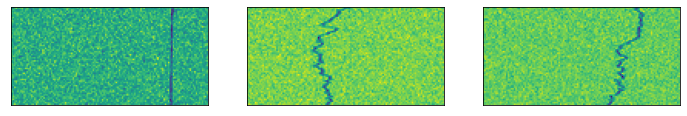

In [10]:
plt.figure(0, figsize=(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = np.squeeze(x_train[i])
    plt.xticks([])
    plt.yticks([]) 
    plt.imshow(img)

### Creating the CNN Model

In [11]:
def cnn(dropout, dropout_f, k_initializer, b_initializer, act, act_o, opt, initial_learning_rate, decay_steps, rho,graph = True, steps = 1000, epochs = 300, nodes_h1 = 32, nodes_h2 = 64, nodes_d = 128, epsilon = 1e-8):
    
    all_data = df.shape[0]

    # Initialising the CNN
    model = Sequential()
    
    # 1st convolution
    model.add(Conv2D(nodes_h1,(5,5), padding = 'same', input_shape = (64, 128,1),
                     kernel_initializer = k_initializer, use_bias = b_initializer))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(dropout))
    
    # 2nd convolution
    model.add(Conv2D(nodes_h2,(5,5), padding = 'same',
                     kernel_initializer = k_initializer, use_bias = b_initializer))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(dropout))

    # flattening
    model.add(Flatten())

    model.add(Dense(4, activation = act_o))

    optimizer =  tf.keras.optimizers.Adagrad(learning_rate = initial_learning_rate, initial_accumulator_value = decay_steps, epsilon = epsilon)

    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(optimizer = opt, loss = loss,metrics = ['accuracy'])

    callback1 = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, 
                                                 verbose = 0,mode = 'min', baseline = None,
                                                 restore_best_weights = True)
    callback2 = tf.keras.callbacks.TerminateOnNaN()
    
    history = model.fit(x_train, y_train, batch_size = int(all_data*(0.7/steps)), steps_per_epoch = steps, validation_data = (x_val, y_val), epochs = epochs, verbose = 1, callbacks = [callback1,callback2])  
    
    
    if graph == True:
        model.summary()
        plt.figure(figsize = (12,5))
        plt.plot(history.history['loss'], alpha = 0.8, label = 'Train')
        plt.plot(history.history['val_loss'], color = 'magenta', alpha = 0.8, label = 'Test')
        plt.title("Loss over epochs", fontsize = 14)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc = 'upper left')
        plt.show()
        
    y_pred = np.zeros(x_test.shape[0])
    predictions = model.predict(x_test)
    for i in range(x_test.shape[0]):
        y_pred[i] = np.round(np.argmax(predictions[i]))
        
    print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_test, y_pred))


    labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]
    confusion = metrics.multilabel_confusion_matrix(y_pred,y_test)
    cm = metrics.confusion_matrix(y_pred,y_test)
    
    # Plot confusion matrix 
    print("confusion matrix")
    fig = plt.figure(figsize = (18, 10))
    sns.heatmap(cm, annot = True, square = True, cbar = False, xticklabels = labels, yticklabels = labels)
    plt.show()
    return model

Epoch 1/300
1000/1000 [==============================] - 46s 46ms/step - loss: 1.1945 - accuracy: 0.5936 - val_loss: 0.5867 - val_accuracy: 0.7038
Epoch 2/300
1000/1000 [==============================] - 46s 46ms/step - loss: 0.8447 - accuracy: 0.6344 - val_loss: 0.5159 - val_accuracy: 0.7250
Epoch 3/300
1000/1000 [==============================] - 45s 45ms/step - loss: 0.7283 - accuracy: 0.6780 - val_loss: 0.4689 - val_accuracy: 0.7319
Epoch 4/300
1000/1000 [==============================] - 45s 45ms/step - loss: 0.6649 - accuracy: 0.6952 - val_loss: 0.4830 - val_accuracy: 0.7344
Epoch 5/300
1000/1000 [==============================] - 45s 45ms/step - loss: 0.6374 - accuracy: 0.7024 - val_loss: 0.4683 - val_accuracy: 0.7487
Epoch 6/300
1000/1000 [==============================] - 45s 45ms/step - loss: 0.6127 - accuracy: 0.7124 - val_loss: 0.4286 - val_accuracy: 0.7500
Epoch 7/300
1000/1000 [==============================] - 45s 45ms/step - loss: 0.5821 - accuracy: 0.7214 - val_loss: 0

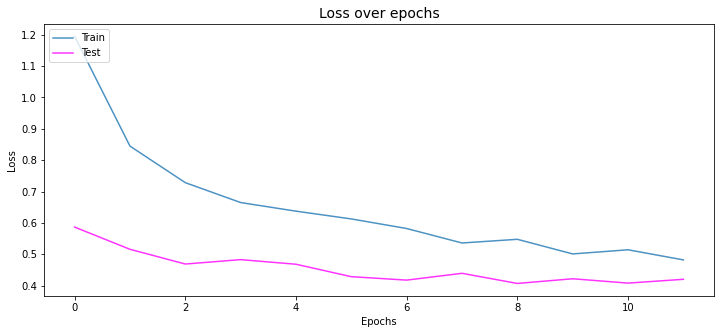

Classification accuracy: 0.752500
confusion matrix


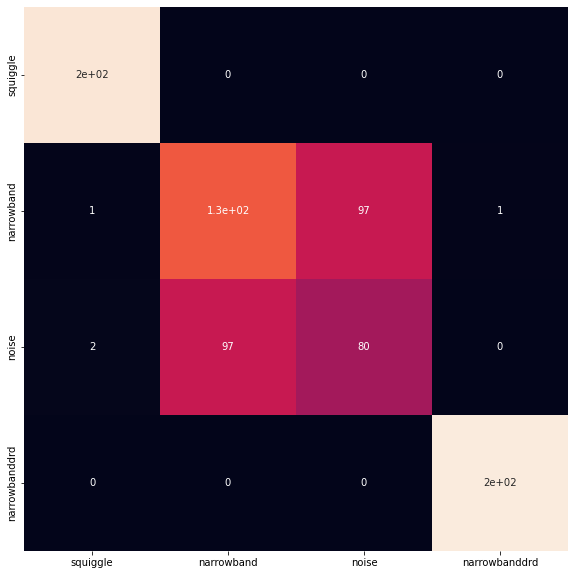

In [12]:
model = cnn(dropout=0.2, dropout_f=0.2, opt='Adagrad', k_initializer='he_uniform', b_initializer='zeros', act='relu',
            act_o='softmax', initial_learning_rate=0.66, decay_steps=0.9, rho=0.96)